# Предсказание уровня экспресси белка

## Описание задачи

Экспрессия — процесс, в ходе которого наследственная информация от гена (последовательности нуклеотидов ДНК) преобразуется в функциональный продукт — белок. Уровнем экспрессии называют - количество белка, производящегося в этом процессе. Чем выше экспрессия белка, тем большее количество этого белка появляется в клетках человека.

Существует множество причин необходимости в знании уровня экспресии белка. Например - это позволяет ученым разрабатывать лекарственные средства и оптимизировать их разработку.

Датасет представляет собой граф взаимойдествия белков. Где узлы это белки, взаимодействие между белками это ребро. 

Для каждого белка известен уровень его экспрессии. Ниже приведен список ребер `edges`. Информация по экспрессии белков, разбитая на `train` и `test`.

## Методология
- Признаки для вершин генерировались с использованием алгоритма `Graph2Vec`, а также добавлялись `degree centrality`, `betweenness centrality`, `closeness centrality`
- Для прогнозирования использовалась модель градиентного бустинга `CatBoostRegressor`
- Подбор гиперпараметров осуществлялся с помощью алгоритма `RandomSearch` из библиотери `hyperopt`

## Оченка качества модели
- `Стандартное отклонение` на тесте: 0.867
- `MSE` на тесте: 0.016
- `R2` на тесте: 0.979
- `MAPE` на тесте: 11%

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
from catboost import CatBoostRegressor
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

In [2]:
random_state = 42
have_model = 0

# Подгрузка данных

In [3]:
# Рёбра графа
edges = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/edges.csv", sep=",")
print(edges.shape)
edges.head()

(594174, 2)


node_1  node_2
0     344      50
1     344     153
2     344     532
3     344     679
4     344     986

In [4]:
# Тренировочная выборка
train = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/train.csv", sep=",")
print(train.shape)
train.head()

(8000, 2)


target   node
0  0.251968  11142
1  0.689541   2243
2  0.678245  15514
3  0.272500  20944
4  0.248888   8721

In [5]:
# Тестовая выборка
test = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/test.csv", sep=",")
print(test.shape)
test.head()

(2000, 2)


target   node
0  0.279231    817
1  0.380795   9574
2  0.686527   1607
3  0.303594   4782
4  0.367374  24125

# Предобработка

Конвертируем граф в networkx и в StellarGraph формат:

In [6]:
G_nx = nx.from_pandas_edgelist(edges, "node_1", "node_2", create_using=nx.Graph())

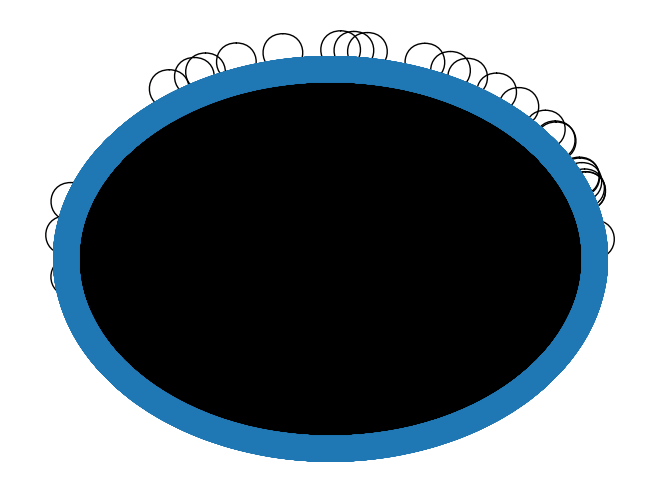

In [7]:
pos = nx.circular_layout(G_nx)
nx.draw(G_nx, with_labels=False, pos=pos)

In [8]:
G = StellarGraph.from_networkx(G_nx)

## Graph2Vec

Сгенерируем признаки методом Graph2Vec. Для этого зададим следующие параметры:
- `len_walk` - длина генерируемого случайного пути
- `num_runs`- количество путей, генерируемых для каждой вершины графа
- `p_ret` - вероятность возврата в начальную вершину в процессе генерации
- `emb_size` - количество генерируемых признаков для вершины
- `num_workers` - количество процессов, используемых при создании модели Word2Vec

In [9]:
len_walk = 20
num_runs = 5
p_ret = 0.4
emb_size = 50
num_workers = 4

In [10]:
rw = BiasedRandomWalk(G)
walks = rw.run(nodes=list(G.nodes()), length=len_walk, n=num_runs, p=p_ret)
str_walks = [list(map(str, w)) for w in walks]
model = Word2Vec(str_walks, vector_size=emb_size, workers=num_workers)

## Генерируем датасеты

Присоединим признаки, сгенерированные Graph2Vec, а также следующие признаки для узлов:
- `degree centrality` - отношение количества связей узла к максимальному количеству возможных связей в графе
- `betweenness centrality` - доля кратчайших путей между всеми парами узлов, которые проходят через этот узел
- `closeness centrality` - обратная сумма кратчайших путей от данного узла до всех других узлов в графе

In [11]:
nodes = G.nodes()
fts = np.array([model.wv[str(node)] for node in nodes])

In [12]:
df_fts = pd.DataFrame(np.column_stack([nodes, fts]))
columns = ['node'] + ['X_{}'.format(i) for i in range(fts.shape[1])]
df_fts.columns = columns
df_fts['node'] = df_fts['node'].astype(int)
print(df_fts.shape)
df_fts.head()

(10000, 51)


node       X_0       X_1       X_2       X_3       X_4       X_5       X_6  \
0   344 -0.007821  0.224046 -0.045171 -0.225787 -0.232245 -0.253175  0.452239   
1    50 -0.089285  0.184488 -0.095860 -0.273787 -0.209547 -0.162620  0.502489   
2   153 -0.120868 -0.484294  0.539567  1.210343 -0.168776 -1.028519  0.174823   
3   532 -0.118604  0.253026 -0.145623 -0.284081 -0.192905 -0.186681  0.449351   
4   679  0.038204  0.459108 -0.212637 -0.632806 -0.376084 -0.058326  0.727754   

        X_7       X_8  ...      X_40      X_41      X_42      X_43      X_44  \
0  0.646387 -0.467420  ...  0.351663 -0.281604  0.092740  0.065282  0.582307   
1  0.642151 -0.413123  ...  0.301869 -0.227178  0.094751 -0.014635  0.551550   
2  0.674999 -0.576893  ...  0.154933  0.214342 -0.244357  0.309669  1.058661   
3  0.642578 -0.441163  ...  0.268607 -0.370177  0.089486 -0.013445  0.456929   
4  0.665984 -0.479881  ...  0.422338 -0.394020  0.220611 -0.043994  0.516741   

       X_45      X_46      X_47      X_48      X_49  
0  0.138433 -0.141460 -0.087991  0.254442  0.396592  
1  0.172813 -0.172497 -0.056174  0.247136  0.412367  
2 -0.299664  0.101745 -0.411862 -0.080333  1.258751  
3  0.261945 -0.231291 -0.064359  0.210554  0.285596  
4  0.264491 -0.147257  0.004179  0.423233  0.311659  

[5 rows x 51 columns]

In [13]:
train = train.merge(df_fts, on='node', how='left')
print(train.shape)
print("Число пропусков:", train.isna().sum().sum())
train.head()

(8000, 52)
Число пропусков: 0


target   node       X_0       X_1       X_2       X_3       X_4  \
0  0.251968  11142 -0.036873  0.013579  0.127093  0.124821 -0.172589   
1  0.689541   2243 -0.115397 -0.227114  0.395578  0.583533 -0.171292   
2  0.678245  15514 -0.032557  0.368611 -0.140937 -0.416168 -0.281444   
3  0.272500  20944 -0.010836  0.276356 -0.089273 -0.274842 -0.240286   
4  0.248888   8721 -0.047655  0.264677 -0.066680 -0.280083 -0.255115   

        X_5       X_6       X_7  ...      X_40      X_41      X_42      X_43  \
0 -0.360022  0.271125  0.403828  ...  0.276140 -0.168527 -0.050007  0.109068   
1 -0.602354  0.189823  0.497505  ...  0.366831 -0.074311 -0.171358  0.246248   
2 -0.178470  0.571888  0.643489  ...  0.394503 -0.364829  0.167459 -0.016855   
3 -0.180988  0.479277  0.577762  ...  0.347063 -0.278815  0.115436  0.003895   
4 -0.167905  0.435898  0.523204  ...  0.315414 -0.263060  0.123139  0.031544   

       X_44      X_45      X_46      X_47      X_48      X_49  
0  0.606710 -0.010396 -0.191106 -0.256079  0.082622  0.470229  
1  0.992177 -0.222259 -0.288279 -0.474299  0.002333  0.889951  
2  0.528065  0.251167 -0.211446 -0.086292  0.343943  0.302506  
3  0.495781  0.174273 -0.188022 -0.065471  0.228182  0.340925  
4  0.475480  0.149370 -0.219319 -0.115862  0.259250  0.316866  

[5 rows x 52 columns]

In [14]:
test = test.merge(df_fts, on='node', how='left')
print(test.shape)
print("Число пропусков:", test.isna().sum().sum())
test.head()

(2000, 52)
Число пропусков: 0


target   node       X_0       X_1       X_2       X_3       X_4  \
0  0.279231    817 -0.067326  0.339694 -0.193322 -0.416191 -0.229430   
1  0.380795   9574 -0.019752  0.212283 -0.039297 -0.178508 -0.268226   
2  0.686527   1607 -0.001235  0.609291 -0.463211 -0.904238 -0.365882   
3  0.303594   4782 -0.078417  0.090846  0.127588  0.031288 -0.194523   
4  0.367374  24125 -0.105472  0.375230 -0.220747 -0.442414 -0.244523   

        X_5       X_6       X_7  ...      X_40      X_41      X_42      X_43  \
0 -0.106625  0.521839  0.601669  ...  0.267924 -0.331563  0.121622 -0.033288   
1 -0.252317  0.463601  0.571568  ...  0.350221 -0.259017  0.094329  0.064272   
2 -0.012227  0.752341  0.811076  ...  0.377480 -0.513604  0.262107 -0.093949   
3 -0.337164  0.346242  0.456198  ...  0.313683 -0.207106  0.011139  0.102597   
4 -0.118925  0.571197  0.678231  ...  0.325179 -0.338184  0.145030 -0.064109   

       X_44      X_45      X_46      X_47      X_48      X_49  
0  0.424578  0.249886 -0.178726 -0.019539  0.255988  0.220544  
1  0.590970  0.103464 -0.197834 -0.139476  0.212761  0.423672  
2  0.430487  0.475739 -0.145716  0.098005  0.459855  0.119427  
3  0.636379  0.028313 -0.212923 -0.242067  0.133770  0.485374  
4  0.471839  0.315504 -0.199415 -0.033596  0.284136  0.275888  

[5 rows x 52 columns]

In [15]:
dc = nx.degree_centrality(G_nx)
bc = nx.betweenness_centrality(G_nx, k=50)
cc = nx.closeness_centrality(G_nx)

In [16]:
df_c = pd.DataFrame({'node': dc.keys(), 'dc': dc.values()})
df_c = df_c.merge(pd.DataFrame({'node': bc.keys(), 'bc': bc.values()}), on='node')
df_c = df_c.merge(pd.DataFrame({'node': cc.keys(), 'cc': cc.values()}), on='node')
print(df_c.shape)
print("Число пропусков:", df_c.isna().sum().sum())
df_c.head()

(10000, 4)
Число пропусков: 0


node        dc        bc        cc
0   344  0.014801  0.000020  0.422970
1    50  0.039404  0.002377  0.503829
2   153  0.194619  0.009648  0.553746
3   532  0.012401  0.000025  0.465265
4   679  0.033703  0.000704  0.497562

In [17]:
train = train.merge(df_c, on='node', how='left')
print(train.shape)
print("Число пропусков:", train.isna().sum().sum())
train.head()

(8000, 55)
Число пропусков: 0


target   node       X_0       X_1       X_2       X_3       X_4  \
0  0.251968  11142 -0.036873  0.013579  0.127093  0.124821 -0.172589   
1  0.689541   2243 -0.115397 -0.227114  0.395578  0.583533 -0.171292   
2  0.678245  15514 -0.032557  0.368611 -0.140937 -0.416168 -0.281444   
3  0.272500  20944 -0.010836  0.276356 -0.089273 -0.274842 -0.240286   
4  0.248888   8721 -0.047655  0.264677 -0.066680 -0.280083 -0.255115   

        X_5       X_6       X_7  ...      X_43      X_44      X_45      X_46  \
0 -0.360022  0.271125  0.403828  ...  0.109068  0.606710 -0.010396 -0.191106   
1 -0.602354  0.189823  0.497505  ...  0.246248  0.992177 -0.222259 -0.288279   
2 -0.178470  0.571888  0.643489  ... -0.016855  0.528065  0.251167 -0.211446   
3 -0.180988  0.479277  0.577762  ...  0.003895  0.495781  0.174273 -0.188022   
4 -0.167905  0.435898  0.523204  ...  0.031544  0.475480  0.149370 -0.219319   

       X_47      X_48      X_49        dc        bc        cc  
0 -0.256079  0.082622  0.470229  0.005001  0.000006  0.458628  
1 -0.474299  0.002333  0.889951  0.019002  0.000056  0.481833  
2 -0.086292  0.343943  0.302506  0.017202  0.000185  0.484072  
3 -0.065471  0.228182  0.340925  0.006101  0.000004  0.432763  
4 -0.115862  0.259250  0.316866  0.006201  0.000006  0.427948  

[5 rows x 55 columns]

In [18]:
test = test.merge(df_c, on='node', how='left')
print(test.shape)
print("Число пропусков:", test.isna().sum().sum())
test.head()

(2000, 55)
Число пропусков: 0


target   node       X_0       X_1       X_2       X_3       X_4  \
0  0.279231    817 -0.067326  0.339694 -0.193322 -0.416191 -0.229430   
1  0.380795   9574 -0.019752  0.212283 -0.039297 -0.178508 -0.268226   
2  0.686527   1607 -0.001235  0.609291 -0.463211 -0.904238 -0.365882   
3  0.303594   4782 -0.078417  0.090846  0.127588  0.031288 -0.194523   
4  0.367374  24125 -0.105472  0.375230 -0.220747 -0.442414 -0.244523   

        X_5       X_6       X_7  ...      X_43      X_44      X_45      X_46  \
0 -0.106625  0.521839  0.601669  ... -0.033288  0.424578  0.249886 -0.178726   
1 -0.252317  0.463601  0.571568  ...  0.064272  0.590970  0.103464 -0.197834   
2 -0.012227  0.752341  0.811076  ... -0.093949  0.430487  0.475739 -0.145716   
3 -0.337164  0.346242  0.456198  ...  0.102597  0.636379  0.028313 -0.212923   
4 -0.118925  0.571197  0.678231  ... -0.064109  0.471839  0.315504 -0.199415   

       X_47      X_48      X_49        dc        bc        cc  
0 -0.019539  0.255988  0.220544  0.007001  0.000006  0.416694  
1 -0.139476  0.212761  0.423672  0.009201  0.000050  0.464098  
2  0.098005  0.459855  0.119427  0.017602  0.000098  0.463625  
3 -0.242067  0.133770  0.485374  0.008301  0.000030  0.465286  
4 -0.033596  0.284136  0.275888  0.007901  0.000005  0.422541  

[5 rows x 55 columns]

# Обучение модели

Обучим CatBoostRegressor с подбором гиперпараметров с использованием алгоритма RandomSearch

In [19]:
train.set_index('node', inplace=True)
X_train, X_val, y_train, y_val = train_test_split(train.drop(['target'], axis=1),
                                                  train['target'],
                                                  test_size=0.2,
                                                  shuffle=True,
                                                  random_state=random_state)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((6400, 53), (1600, 53), (6400,), (1600,))

In [20]:
catboost_params = {
    'iterations': 1000,
    'cat_features': None,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_state': random_state,
    'thread_count': -1
}
space = {
    'learning_rate': hp.uniform('learning_rate', 0.00001, 1),
    'depth': hp.randint('depth', 1, 10),
    'min_data_in_leaf': hp.randint('min_data_in_leaf', 5, 30),
    'subsample': hp.uniform('subsample', 0.1, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 0.95),
    'max_bin': hp.randint('max_bin', 100, 500),
    'one_hot_max_size': hp.randint('one_hot_max_size', 3, 20),
}
if not have_model:

    def objective(ctb_space):
        curr_model = CatBoostRegressor(**ctb_space, **catboost_params)
        curr_model.fit(X_train,
                       y_train,
                       eval_set=[(X_val, y_val)],
                       use_best_model=True,
                       early_stopping_rounds=50,
                       verbose=0,
                       plot=False)
        val_pred = curr_model.predict(X_val)
        curr_loss = mean_squared_error(y_val, val_pred)
        return {'loss': curr_loss, 'status': STATUS_OK, 'params': ctb_space}

    trials = Trials()
    best = fmin(objective,
                space,
                algo=tpe.suggest,
                max_evals=300,
                trials=trials,
                rstate=np.random.default_rng(random_state))

    print('Best hyperparameters:', best)
    model = CatBoostRegressor(**best, **catboost_params)
    model.fit(train.drop(['target'], axis=1),
              train['target'],
              use_best_model=True,
              early_stopping_rounds=50,
              verbose=0,
              plot=False)
    model.save_model('models/ctb_model.cbm', format='cbm')
    print(f"Train MSE: {mean_squared_error(model.predict(X_train), y_train)}")
    print(f"Val MSE: {mean_squared_error(model.predict(X_val), y_val)}\n")
else:
    model = CatBoostRegressor().load_model('models/ctb_model.cbm')
    print(f"Train MSE: {mean_squared_error(model.predict(X_train), y_train)}")
    print(f"Val MSE: {mean_squared_error(model.predict(X_val), y_val)}\n")

100%|██████████| 300/300 [03:46<00:00,  1.33trial/s, best loss: 0.013835820252662317]
Best hyperparameters: {'colsample_bylevel': 0.877179070750049, 'depth': 1, 'learning_rate': 0.039570460172658944, 'max_bin': 491, 'min_data_in_leaf': 24, 'one_hot_max_size': 18, 'subsample': 0.2570100453978877}


You should provide test set for use best model. use_best_model parameter has been switched to false value.


Train MSE: 0.008303355861646971
Val MSE: 0.008263469553623474



In [21]:
print(f"X_train std: {round(y_train.std(), 3)}")
print(f"X_val std: {round(y_val.std(), 3)}\n")
print(f"X_train MSE: {round(mean_squared_error(model.predict(X_train), y_train), 3)}")
print(f"X_val MSE: {round(mean_squared_error(model.predict(X_val), y_val), 3)}\n")
print(f"X_train R2: {round(r2_score(y_train, model.predict(X_train)), 3)}")
print(f"X_val R2: {round(r2_score(y_val, model.predict(X_val)), 3)}\n")
print(f"X_train MAPE: {round(mean_absolute_percentage_error(y_train, model.predict(X_train)), 3)}")
print(f"X_val MAPE: {round(mean_absolute_percentage_error(y_val, model.predict(X_val)), 3)}")

X_train std: 0.641
X_val std: 0.789

X_train MSE: 0.008
X_val MSE: 0.008

X_train R2: 0.98
X_val R2: 0.987

X_train MAPE: 0.114
X_val MAPE: 0.115


# Оценка качества

In [22]:
test.set_index('node', inplace=True)
X_test, y_test = test.drop(['target'], axis=1), test['target']

In [23]:
print(f"Test std: {round(y_test.std(), 3)}")
print(f"Test MSE: {round(mean_squared_error(model.predict(X_test), y_test), 3)}")
print(f"Test R2: {round(r2_score(y_test, model.predict(X_test)), 3)}")
print(f"Test MAPE: {round(mean_absolute_percentage_error(y_test, model.predict(X_test)), 3)}")

Test std: 0.867
Test MSE: 0.016
Test R2: 0.979
Test MAPE: 0.11
